# Lab 1: Markov Decision Processes - Dynamic Programming

## Lab Instructions
To complete the homework, you only need to modify the code in this notebook. 

**You should execute every block of code to not miss any dependency.**

*This exercise is adapted from Berkeley Deep RL Class [HW2](https://github.com/berkeleydeeprlcourse/homework/blob/c1027d83cd542e67ebed982d44666e0d22a00141/hw2/HW2.ipynb) [(license)](https://github.com/berkeleydeeprlcourse/homework/blob/master/LICENSE)*

--------------------------

## Introduction

In this lab, we will solve **Markov Decision Processes (MDPs) with finite state and action spaces** with several classic algorithms that you learnt in the class.

The experiments here will use the Frozen Lake environment, a simple gridworld MDP that is taken from `gym` and slightly modified for this assignment. In this MDP, the agent must navigate from the start state to the goal state on a 4x4 grid, with stochastic transitions.

In [1]:
from misc import FrozenLakeEnv, make_grader
env = FrozenLakeEnv()
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


Let's look at what a random episode looks like.

In [2]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)
# Generate the episode
env.reset()
for t in range(100):
    env.render()
    a = env.action_space.sample()
#     print('a = ',a)
    ob, rew, done, _ = env.step(a)
#     print('ob = ',ob)
#     print('rew = ',rew)
#     print('done = ',done)
    if done:
        break
assert done
env.render();


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


In the episode above, the agent falls into a hole after two timesteps. Also note the stochasticity--on the first step, the DOWN action is selected, but the agent moves to the right.

We extract the relevant information from the gym Env into the MDP class below.
The ```env``` object won't be used any further, we'll just use the ```mdp``` object.

In [3]:
# check for some basic setting
# for s, a2d in enumerate(env.P.items()):
#     print ('s = %s, a2d = %s\n' % (s, a2d))

In [4]:
class MDP(object):
    def __init__(self, P, nS, nA, desc=None):
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
mdp = MDP( {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc)


print("mdp.P is a two-level dict where the first key is the state and the second key is the action.")
print("The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in")
print(np.arange(16).reshape(4,4))
print("Action indices [0, 1, 2, 3] correspond to West, South, East and North.")
print("mdp.P[state][action] is a list of tuples (probability, nextstate, reward).\n")
print("For example, state 0 is the initial state, and the transition information for s=0, a=0 is \nP[0][0] =", mdp.P[0][0], "\n")
print("As another example, state 5 corresponds to a hole in the ice, in which all actions lead to the same state with probability 1 and reward 0.")
for i in range(4):
    print("P[5][%i] =" % i, mdp.P[5][i])
    
# print out to clarify its dict-structure
for key, val in mdp.P.items():
    print('========== in state %s =========='% str(key))
    for ac_key, ac_val in val.items():
        for i in range(len(ac_val)):
            print('state %s, action %s, (prob, next-s, rw) = %s' %(str(key), str(ac_key), str(ac_val[i])))


mdp.P is a two-level dict where the first key is the state and the second key is the action.
The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
Action indices [0, 1, 2, 3] correspond to West, South, East and North.
mdp.P[state][action] is a list of tuples (probability, nextstate, reward).

For example, state 0 is the initial state, and the transition information for s=0, a=0 is 
P[0][0] = [(0.1, 0, 0.0), (0.8, 0, 0.0), (0.1, 4, 0.0)] 

As another example, state 5 corresponds to a hole in the ice, in which all actions lead to the same state with probability 1 and reward 0.
P[5][0] = [(1.0, 5, 0)]
P[5][1] = [(1.0, 5, 0)]
P[5][2] = [(1.0, 5, 0)]
P[5][3] = [(1.0, 5, 0)]
========== in state 0 ==========
state 0, action 0, (prob, next-s, rw) = (0.1, 0, 0.0)
state 0, action 0, (prob, next-s, rw) = (0.8, 0, 0.0)
state 0, action 0, (prob, next-s, rw) = (0.1, 4, 0.0)
state 0, acti

### Problem 1: implement value iteration
In this problem, you'll implement value iteration, which has the following pseudocode:

---
Initialize $V^{(0)}(s)=0$, for all $s$

For $i=0, 1, 2, \dots$
- $V^{(i+1)}(s) = \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$, for all $s$

---

We additionally define the sequence of greedy policies $\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}$, where
$$\pi^{(i)}(s) = \arg \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$$

Your code will return two lists: $[V^{(0)}, V^{(1)}, \dots, V^{(n)}]$ and $[\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}]$

To ensure that you get the same policies as the reference solution, **choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by np.argmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.**

<div class="alert alert-warning">
Warning: make a copy of your value function each iteration and use that copy for the update--don't update your value function in place. 
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than our reference solution (which in turn will mean that our testing code won’t be able to help in verifying your code).
</div>

In [5]:
# print(mdp.nS)
# print([np.zeros(mdp.nS)])
# print([np.zeros(mdp.nS)][-1])
# print(float("-inf"))
# print(mdp.P.keys())
# print(mdp.P[0][0])
# print(np.zeros(mdp.nS))

In [6]:
def value_iteration(mdp, gamma, nIt, grade_print=print):
    """
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)
        
    len(value_functions) == nIt+1 and len(policies) == nIt
    """
    grade_print("Iteration | max|V-Vprev| | # chg actions | V[0]")
    grade_print("----------+--------------+---------------+---------")
    Vs = [np.zeros(mdp.nS)] # list of value functions contains the initial value function V^{(0)}, which is zero
    pis = []
    actions = [0,1,2,3]
    states = list(range(mdp.nS))
    for it in range(nIt):
        if it == 0:
            oldpi = pis[-1] if len(pis) > 0 else None # \pi^{(it)} = Greedy[V^{(it-1)}]. Just used for printout
            Vprev = Vs[-1] # V^{(it)} = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
        
        # V is an ary which specify [V(0),V(1).....V(15)] 
        V = np.zeros(mdp.nS)
        pi = np.zeros(mdp.nS) # initial as 'Left'
        for _, state in enumerate(states):
            # V^{(it)}(s) and Pi^{(it)}(s)
            V_ele = float("-inf")
            pi_ele = None
            V_ele_ary = []
            for ac_idx, action in enumerate(actions):
                current_val = 0
                # enumerate through the transition_list, sum up the result of all possible states
                for _, transition in enumerate(mdp.P[state][action]): #first get dict-val from key:state, then get value, [(p,s,rw),(p,s,rw),(p,s,rw)], from key:action 
                    prob = transition[0]
                    rw = transition[2]
                    next_s = transition[1]
                    current_val += prob*(rw+gamma*Vprev[next_s])
                    
                # prepare to find pi
                V_ele_ary.append(current_val)
                if current_val > V_ele:
                    V_ele = current_val


            pi_ele = np.argmax(np.asarray(V_ele_ary))

            V[state] = V_ele
            pi[state] = pi_ele
        
        max_diff = np.abs(V - Vprev).max()
        nChgActions="N/A" if oldpi is None else (pi != oldpi).sum()
        grade_print("%4i      | %6.5f      | %4s          | %5.3f"%(it, max_diff, nChgActions, V[0]))
        Vs.append(V)
        pis.append(pi)
        nChgActions_ary.append(nChgActions)
        max_diff_ary.append(max_diff)
        
        # make a copy of value function
        Vprev = V
        oldpi = pi
#         if it ==0 :
#             print('it = 0 result')
#             print(Vprev)
#             print(oldpi)
#         if it ==1 :
#             print('it = 1 result')
#             print(Vprev)
#             print(oldpi)
    return Vs, pis

GAMMA = 0.95 # we'll be using this same value in subsequent problems


# The following is the output of a correct implementation; when
#   this code block is run, your implementation's print output will be
#   compared with expected output.
#   (incorrect line in red background with correct line printed side by side to help you debug)
expected_output = """Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
   0      | 0.80000      |  N/A          | 0.000
   1      | 0.60800      |    2          | 0.000
   2      | 0.51984      |    2          | 0.000
   3      | 0.39508      |    2          | 0.000
   4      | 0.30026      |    2          | 0.000
   5      | 0.25355      |    1          | 0.254
   6      | 0.10478      |    0          | 0.345
   7      | 0.09657      |    0          | 0.442
   8      | 0.03656      |    0          | 0.478
   9      | 0.02772      |    0          | 0.506
  10      | 0.01111      |    0          | 0.517
  11      | 0.00735      |    0          | 0.524
  12      | 0.00310      |    0          | 0.527
  13      | 0.00190      |    0          | 0.529
  14      | 0.00083      |    0          | 0.530
  15      | 0.00049      |    0          | 0.531
  16      | 0.00022      |    0          | 0.531
  17      | 0.00013      |    0          | 0.531
  18      | 0.00006      |    0          | 0.531
  19      | 0.00003      |    0          | 0.531"""
max_diff_ary = []
nChgActions_ary = []
Vs_VI, pis_VI = value_iteration(mdp, gamma=GAMMA, nIt=20, grade_print=make_grader(expected_output))

Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
   0      | 0.80000      |  N/A          | 0.000
   1      | 0.60800      |    2          | 0.000
   2      | 0.51984      |    2          | 0.000
   3      | 0.39508      |    2          | 0.000
   4      | 0.30026      |    2          | 0.000
   5      | 0.25355      |    1          | 0.254
   6      | 0.10478      |    0          | 0.345
   7      | 0.09657      |    0          | 0.442
   8      | 0.03656      |    0          | 0.478
   9      | 0.02772      |    0          | 0.506
  10      | 0.01111      |    0          | 0.517
  11      | 0.00735      |    0          | 0.524
  12      | 0.00310      |    0          | 0.527
  13      | 0.00190      |    0          | 0.529
  14      | 0.00083      |    0          | 0.530
  15      | 0.00049      |    0          | 0.531
  16      | 0.00022      |    0          | 0.531
  17      | 0.00013      |    0          | 0.531
  18      | 0.0000

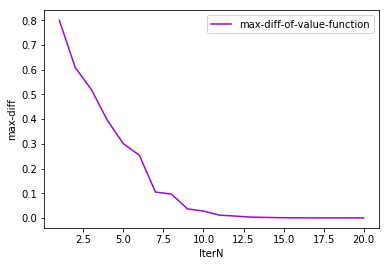

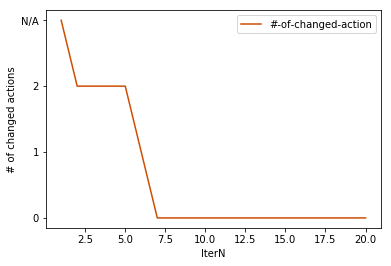

In [7]:
# Visualize the difference current iteration and previous iteration
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(1,21),max_diff_ary ,color=colors[1], label='max-diff-of-value-function'.format(i=0))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
plt.legend(loc='best')
plt.xlabel('IterN')
plt.ylabel('max-diff')
plt.savefig('./imgs/max-diff-value-function')

plt.show()
plt.close(fig)

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(1,21),nChgActions_ary ,color=colors[2], label='#-of-changed-action'.format(i=0))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
plt.legend(loc='best')
plt.xlabel('IterN')
plt.ylabel('# of changed actions')
plt.savefig('./imgs/NchgAction')

plt.show()
plt.close(fig)

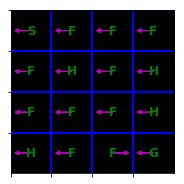

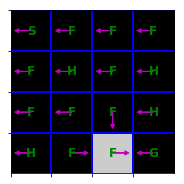

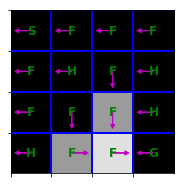

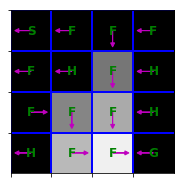

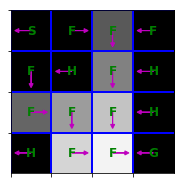

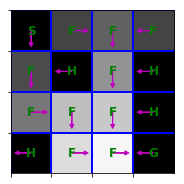

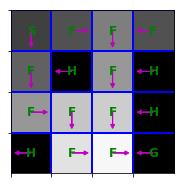

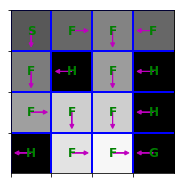

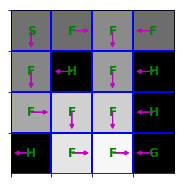

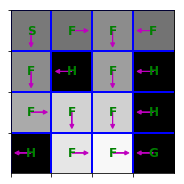

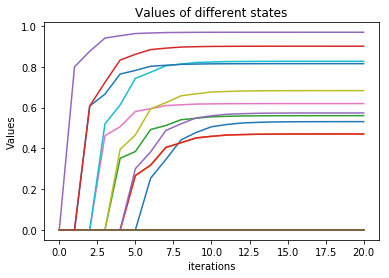

In [8]:
# Visualize the estimated values and corresponding policy
for (V, pi) in zip(Vs_VI[:10], pis_VI[:10]):
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(4)-.5)
    ax.set_yticks(np.arange(4)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
    Pi = pi.reshape(4,4)
    for y in range(4):
        for x in range(4):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    plt.grid(color='b', lw=2, ls='-')
plt.figure()
plt.plot(Vs_VI)
plt.xlabel("iterations")
plt.ylabel("Values")
plt.title("Values of different states");
plt.savefig('./imgs/value-converge-on-each-state')

## Problem 2: Policy Iteration

The next task is to implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Below, you'll implement the first and second steps of the loop step by step.

### Problem 2a: state value function

You'll write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.
Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

**Here, we're going to solve the exact value function. You can solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)**

In [9]:
# solve the exact values with `np.linalg.solve`

def compute_vpi(pi, mdp, gamma):
    # use pi[state] to access the action that's prescribed by this policy
    # V[s] = P*(R + \gamma*V[s'])
    # => (I-\gamma*P)*V = P*R
    # solve linear matrix
    # (I-\gamma*P): (nS, nS) => a
    # P*R => b
    
   
    a = np.zeros((mdp.nS, mdp.nS)) 
    b = np.zeros(mdp.nS) 
    
    # find V^{(pi)}(s)
    for state in range(mdp.nS):
        # assign actual action and set a[s][s] = 1 since it will be on the left side of the equation.
        ac = pi[state]
        a[state][state] = 1
        # enumerate through the transition_list
        for _, transition in enumerate(mdp.P[state][ac]):
            prob = transition[0]
            next_s = transition[1]
            rw = transition[2]
            # fill in the equation coefficient, a, and it's corresponding value, b.
            a[state][next_s] -= gamma*prob
            b[state] += prob*rw
    
    V = np.linalg.solve(a, b)
#     print('shape of V = ',V.shape)
    
    return V

Now let's compute the value of an arbitrarily-chosen policy. 

In [10]:
expected_val = np.load('compute_vpi_result.npy')
policy = np.array([1, 0, 3, 3, 1, 3, 3, 1, 2, 2, 1, 1, 0, 3, 3, 3])
actual_val = compute_vpi(policy, mdp, gamma=GAMMA)
# print(type(actual_val))
# print(actual_val.shape)
if np.all(np.isclose(actual_val, expected_val, atol=1e-4)):
    print("Test passed")
else:
    print("Expected: ", expected_val)
    print("Actual: ", actual_val)

Test passed


In [11]:
# print('dim of V = ',actual_val.shape)
# print(actual_val)

### Problem 2b: state-action value function

Next, you'll write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q^{\pi}(s, a) = \sum_{s'} P(s,a,s')[ R(s,a,s') + \gamma V^{\pi}(s')]$$



In [12]:
# print(mdp.nA)

In [13]:
def compute_qpi(vpi, mdp, gamma):
    Qpi = np.zeros([mdp.nS, mdp.nA])
    for state in range(mdp.nS):
        for action in range(mdp.nA):
            sum_val = 0
            for _, transition in enumerate(mdp.P[state][action]):
                prob = transition[0]
                next_s = transition[1]
                rw = transition[2]
                sum_val += prob*(rw + gamma*vpi[next_s])
            Qpi[state][action] = sum_val
    
    return Qpi

expected_Qpi = np.array([[  0.38 ,   3.135,   1.14 ,   0.095],
       [  0.57 ,   3.99 ,   2.09 ,   0.95 ],
       [  1.52 ,   4.94 ,   3.04 ,   1.9  ],
       [  2.47 ,   5.795,   3.23 ,   2.755],
       [  3.8  ,   6.935,   4.56 ,   0.855],
       [  4.75 ,   4.75 ,   4.75 ,   4.75 ],
       [  4.94 ,   8.74 ,   6.46 ,   2.66 ],
       [  6.65 ,   6.65 ,   6.65 ,   6.65 ],
       [  7.6  ,  10.735,   8.36 ,   4.655],
       [  7.79 ,  11.59 ,   9.31 ,   5.51 ],
       [  8.74 ,  12.54 ,  10.26 ,   6.46 ],
       [ 10.45 ,  10.45 ,  10.45 ,  10.45 ],
       [ 11.4  ,  11.4  ,  11.4  ,  11.4  ],
       [ 11.21 ,  12.35 ,  12.73 ,   9.31 ],
       [ 12.16 ,  13.4  ,  14.48 ,  10.36 ],
       [ 14.25 ,  14.25 ,  14.25 ,  14.25 ]])

Qpi = compute_qpi(np.arange(mdp.nS), mdp, gamma=GAMMA)
if np.all(np.isclose(expected_Qpi, Qpi, atol=1e-4)):
    print("Test passed")
else:
    print("Expected: ", expected_Qpi)
    print("Actual: ", Qpi)

Test passed


Now we're going to run the poolicy iteration!

#### Policy improvement (outer iteration)
keep update the best policy in each iteration, the formula goes as follows:

$${\pi}_{nIt}(s) <- \arg \max_a \sum_{s'} P(s,a,s')[ R(s,a,s') + \gamma V^{\pi}_{nIt}(s')]$$



Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      1        | -0.00000
   1      |      9        | 0.00000
   2      |      2        | 0.39785
   3      |      1        | 0.45546
   4      |      0        | 0.53118
   5      |      0        | 0.53118
   6      |      0        | 0.53118
   7      |      0        | 0.53118
   8      |      0        | 0.53118
   9      |      0        | 0.53118
  10      |      0        | 0.53118
  11      |      0        | 0.53118
  12      |      0        | 0.53118
  13      |      0        | 0.53118
  14      |      0        | 0.53118
  15      |      0        | 0.53118
  16      |      0        | 0.53118
  17      |      0        | 0.53118
  18      |      0        | 0.53118
  19      |      0        | 0.53118
Test succeeded


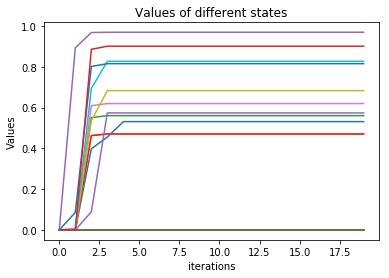

In [14]:

def policy_iteration(mdp, gamma, nIt, grade_print=print):
    Vs = []
    pis = []
    pi_prev = np.zeros(mdp.nS,dtype='int')
    pis.append(pi_prev)
    grade_print("Iteration | # chg actions | V[0]")
    grade_print("----------+---------------+---------")
    for it in range(nIt):
        # you need to compute qpi which is the state-action values for current pi
        #               and compute the greedily policy, pi, from qpi
        vpi = compute_vpi(pi_prev, mdp, gamma=GAMMA)
        Qpi = compute_qpi(vpi, mdp, gamma=GAMMA)
        # find mximum index for each state, i.e. for each row in Qpi
        pi = np.argmax(Qpi, axis = 1)
        
        grade_print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        Chgac_ary.append((pi != pi_prev).sum())
        
        pi_prev = pi

    return Vs, pis

expected_output = """Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      1        | -0.00000
   1      |      9        | 0.00000
   2      |      2        | 0.39785
   3      |      1        | 0.45546
   4      |      0        | 0.53118
   5      |      0        | 0.53118
   6      |      0        | 0.53118
   7      |      0        | 0.53118
   8      |      0        | 0.53118
   9      |      0        | 0.53118
  10      |      0        | 0.53118
  11      |      0        | 0.53118
  12      |      0        | 0.53118
  13      |      0        | 0.53118
  14      |      0        | 0.53118
  15      |      0        | 0.53118
  16      |      0        | 0.53118
  17      |      0        | 0.53118
  18      |      0        | 0.53118
  19      |      0        | 0.53118"""

Chgac_ary = []
Vs_PI, pis_PI = policy_iteration(mdp, gamma=0.95, nIt=20, grade_print=make_grader(expected_output))
plt.plot(Vs_PI);
plt.xlabel("iterations")
plt.ylabel("Values")
plt.title("Values of different states");
plt.savefig('./imgs/policy-converge-on-each-state')

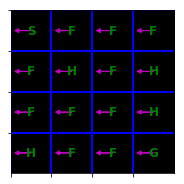

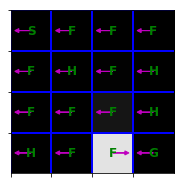

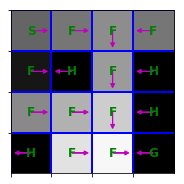

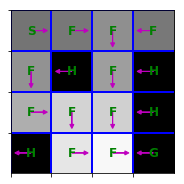

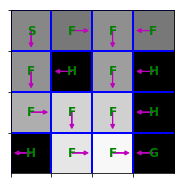

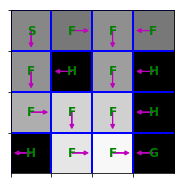

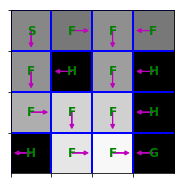

In [15]:
# Visualize policy gradient result
for (V, pi) in zip(Vs_PI[:7], pis_PI[:7]):
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(4)-.5)
    ax.set_yticks(np.arange(4)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
    Pi = pi.reshape(4,4)
    for y in range(4):
        for x in range(4):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    plt.grid(color='b', lw=2, ls='-')

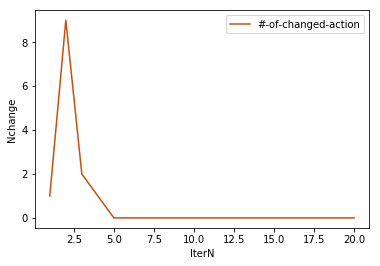

In [16]:
# Visualize the number of change of actions
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(1,21),Chgac_ary ,color=colors[2], label='#-of-changed-action'.format(i=0))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
plt.legend(loc='best')
plt.xlabel('IterN')
plt.ylabel('Nchange')
plt.savefig('./imgs/N-of-change-of-state-value-function')

plt.show()
plt.close(fig)



### Problem 3: Sampling-based Tabular Q-Learning

So far we have implemented Value Iteration and Policy Iteration, both of which require access to an MDP's dynamics model. This requirement can sometimes be restrictive - for example, if the environment is given as a blackbox physics simulator, then we won't be able to read off the whole transition model.

We can however use sampling-based Q-Learning to learn from this type of environments. 

For this exercise, we will learn to control a Crawler robot. Let's first try some completely random actions to see how the robot moves and familiarize ourselves with Gym environment interface again.

In [17]:
from crawler_env import CrawlingRobotEnv

env = CrawlingRobotEnv()

print("the state of the crawler - Arm:\n" , env.armBuckets)
print("the state of the crawler - Hand:\n" , env.handBuckets)
print("-----------------------------------------------------------------------------")

print("We can inspect the observation space and action space of this Gym Environment")
print("-----------------------------------------------------------------------------")
print("Action space:", env.action_space)
print("It's a discrete space with %i actions to take" % env.action_space.n)
print("Each action corresponds to increasing/decreasing the angle of one of the joints")
print("We can also sample from this action space:", env.action_space.sample())
print("Another action sample:", env.action_space.sample())
print("Another action sample:", env.action_space.sample())
print("Observation space:", env.observation_space, ", which means it's a 9x13 grid.")
print("It's the discretized version of the robot's two joint angles")

the state of the crawler - Arm:
 [-0.5235987755982988, -0.39269908169872414, -0.2617993877991494, -0.13089969389957468, 0.0, 0.13089969389957468, 0.26179938779914946, 0.39269908169872414, 0.5235987755982988]
the state of the crawler - Hand:
 [-2.6179938779914944, -2.399827721492203, -2.181661564992912, -1.9634954084936207, -1.7453292519943298, -1.5271630954950384, -1.3089969389957472, -1.090830782496456, -0.8726646259971649, -0.6544984694978737, -0.43633231299858233, -0.21816615649929139, 0.0]
-----------------------------------------------------------------------------
We can inspect the observation space and action space of this Gym Environment
-----------------------------------------------------------------------------
Action space: Discrete(4)
It's a discrete space with 4 actions to take
Each action corresponds to increasing/decreasing the angle of one of the joints
We can also sample from this action space: 0
Another action sample: 3
Another action sample: 0
Observation space: Tu

In [28]:
env = CrawlingRobotEnv(
    render=True, # turn render mode on to visualize random motion
)

# standard procedure for interfacing with a Gym environment
cur_state = env.reset() # reset environment and get initial state
ret = 0.
done = False
i = 0
while not done:
    action = env.action_space.sample() # sample an action randomly
    next_state, reward, done, info = env.step(action)
    ret += reward
    cur_state = next_state
    i += 1
    if i == 1500:
        break # for the purpose of this visualization, let's only run for 1500 steps
        # also note the GUI won't close automatically

In [29]:
# you can close the visualization GUI with the following method 
env.close_gui()

You will see the random controller can sometimes make progress but it won't get very far. Let's implement Tabular Q-Learning with $\epsilon$-greedy exploration to find a better policy piece by piece.

In [18]:
from collections import defaultdict
import random

# dictionary that maps from state, s, to a numpy array of Q values [Q(s, a_1), Q(s, a_2) ... Q(s, a_n)]
#   and everything is initialized to 0.
q_vals = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))
print("Q-values for state (0, 0): %s" % q_vals[(0, 0)], "which is a list of Q values for each action")
print("As such, the Q value of taking action 3 in state (1,2), i.e. Q((1,2), 3), can be accessed by q_vals[(1,2)][3]:", q_vals[(1,2)][3])

Q-values for state (0, 0): [ 0.  0.  0.  0.] which is a list of Q values for each action
As such, the Q value of taking action 3 in state (1,2), i.e. Q((1,2), 3), can be accessed by q_vals[(1,2)][3]: 0.0


In [19]:
# print(q_vals.items())
# print(env)
# print(random.uniform(0, 1))

In [20]:
def eps_greedy(q_vals, eps, state):
    """
    Inputs:
        q_vals: q value tables
        eps: epsilon
        state: current state
    Outputs:
        random action with probability of eps; argmax Q(s, .) with probability of (1-eps)
    """
    # you might want to use random.random() to implement random exploration
    #   number of actions can be read off from len(q_vals[state])
    import random
    ac_choice = q_vals[state]
    ranN = random.uniform(0, 1)
    if ranN < eps:
        action = random.randint(0,len(ac_choice)-1) # it's actually 4 lol.. seems that each state all have 4 choices of actions
    else:
        action = np.argmax(ac_choice)
    
    return action

# test case 1
dummy_q = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))
test_state = (0, 0)
dummy_q[test_state][0] = 10.
trials = 100000
sampled_actions = [
    int(eps_greedy(dummy_q, 0.3, test_state))
    for _ in range(trials)
]
print()
freq = np.sum(np.array(sampled_actions) == 0) / trials
tgt_freq = 0.3 / env.action_space.n + 0.7
if np.isclose(freq, tgt_freq, atol=1e-2):
    print("Test1 passed")
else:
    print("Test1: Expected to select 0 with frequency %.2f but got %.2f" % (tgt_freq, freq))
    
# test case 2
dummy_q = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))
test_state = (0, 0)
dummy_q[test_state][2] = 10.
trials = 100000
sampled_actions = [
    int(eps_greedy(dummy_q, 0.5, test_state))
    for _ in range(trials)
]
freq = np.sum(np.array(sampled_actions) == 2) / trials
tgt_freq = 0.5 / env.action_space.n + 0.5
if np.isclose(freq, tgt_freq, atol=1e-2):
    print("Test2 passed")
else:
    print("Test2: Expected to select 2 with frequency %.2f but got %.2f" % (tgt_freq, freq))


Test1 passed
Test2 passed


Next we will implement Q learning update. After we observe a transition $s, a, s', r$,

$$\textrm{target}(s') = R(s,a,s') + \gamma \max_{a'} Q_{\theta_k}(s',a')$$


$$Q_{k+1}(s,a) \leftarrow (1-\alpha) Q_k(s,a) + \alpha \left[ \textrm{target}(s') \right]$$

In [21]:
def q_learning_update(gamma, alpha, q_vals, cur_state, action, next_state, reward):
    """
    Inputs:
        gamma: discount factor
        alpha: learning rate
        q_vals: q value table
        cur_state: current state
        action: action taken in current state
        next_state: next state results from taking `action` in `cur_state`
        reward: reward received from this transition
    
    Performs in-place update of q_vals table to implement one step of Q-learning
    """
    target_next_state = reward + gamma*np.amax(q_vals[next_state]) # return the maximum q-val among 4-diff actions-result
    update_q = (1.0-alpha)*q_vals[cur_state][action] + alpha*target_next_state # this action has eps-probs to be random-sampled
    q_vals[cur_state][action] = update_q
    
# testing your q_learning_update implementation
dummy_q = q_vals.copy()
test_state = (0, 0)
test_next_state = (0, 1)
dummy_q[test_state][0] = 10.
dummy_q[test_next_state][1] = 10.
q_learning_update(0.9, 0.1, dummy_q, test_state, 0, test_next_state, 1.1)
tgt = 10.01
if np.isclose(dummy_q[test_state][0], tgt,):
    print("Test passed")
else:
    print("Q(test_state, 0) is expected to be %.2f but got %.2f" % (tgt, dummy_q[test_state][0]))

Test passed


Itr 0 # Average speed: 0.05


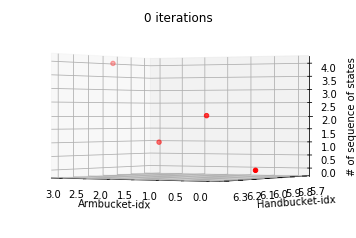

Itr 50000 # Average speed: 2.03


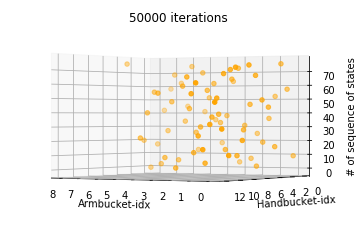

Itr 100000 # Average speed: 3.37


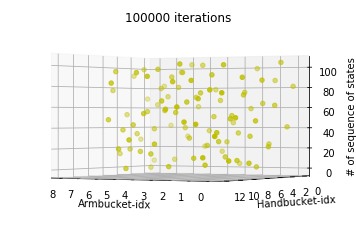

Itr 150000 # Average speed: 3.37


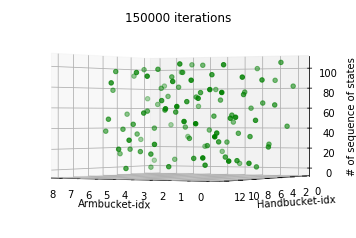

Itr 200000 # Average speed: 3.37


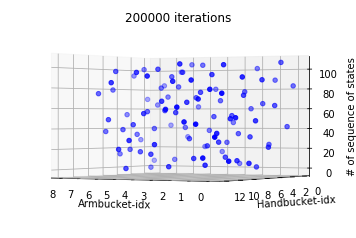

Itr 250000 # Average speed: 3.37


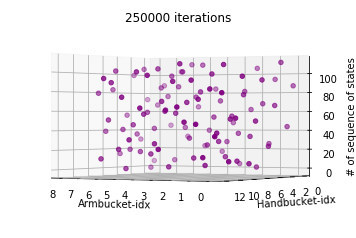

In [22]:
# now with the main components tested, we can put everything together to create a complete q learning agent

env = CrawlingRobotEnv() 
q_vals = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))
gamma = 0.9
alpha = 0.1
eps = 0.5
cur_state = env.reset()

def greedy_eval():
    """evaluate greedy policy w.r.t current q_vals"""
    test_env = CrawlingRobotEnv(horizon=np.inf)
    prev_state = test_env.reset()
    ret = 0.
    done = False
    H = 100
    for i in range(H):
        action = np.argmax(q_vals[prev_state])
        state, reward, done, info = test_env.step(action)
        ret += reward
        prev_state = state
    return ret / H

# visualize Armbucket, handbucket, # of q-values
from mpl_toolkits.mplot3d import Axes3D

def Draw(q_vals,color):
    arms_ = []
    hands_ = []
    order_ = []
    for idx, key in enumerate(q_vals):
        if key == None:
            continue
        arms_.append(key[0])
        hands_.append(key[1])
        order_.append(idx)

    for c, m in [(color, 'o')]:
        xs = arms_
        ys = hands_
        zs = order_
        ax.scatter(xs, ys, zs, c=c, marker=m)

    ax.set_xlabel('Armbucket-idx')
    ax.set_ylabel('Handbucket-idx')
    ax.set_zlabel('# of sequence of states')

    
    
    
color = ['r','orange','y','g','b','purple','gray']
q_vals_ary = []
visit = 0
for itr in range(300000):  
    sampled_ac = eps_greedy(q_vals, eps, cur_state)
    next_state, reward, done, info = env.step(sampled_ac)
    q_learning_update(gamma, alpha, q_vals, cur_state, sampled_ac, next_state, reward)
    cur_state = next_state
    
    
    if itr % 50000 == 0: # evaluation
        print("Itr %i # Average speed: %.2f" % (itr, greedy_eval()))
        q_vals_ary.append(list(q_vals.keys()))

        # draw 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(0, 120)
        ax.set_title('%s iterations' % str(itr))
        Draw(q_vals,color[visit])
        
        plt.savefig('./imgs/'+str(itr)+'-itr-of-state-changes')
        plt.show()
        plt.close(fig)
        visit += 1


# at the end of learning your crawler should reach a speed of >= 3

The average speed should be around 3.37

After the learning is successful, we can visualize the learned robot controller. Remember we learn this just from interacting with the environment instead of peeking into the dynamics model!

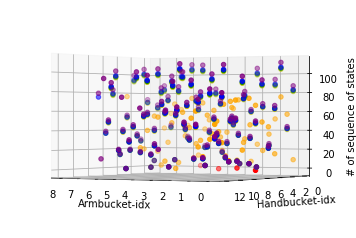

In [23]:
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.view_init(0, 120)

for i, qvals in enumerate(q_vals_ary):
    arms_ = []
    hands_ = []
    order_ = []
    for idx, key in enumerate(qvals):
        if key == None:
            continue
        arms_.append(key[0])
        hands_.append(key[1])
        order_.append(idx)

    for c, m in [(color[i],'o')]:
        xs = arms_
        ys = hands_
        zs = order_
        ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('Armbucket-idx')
ax.set_ylabel('Handbucket-idx')
ax.set_zlabel('# of sequence of states')

plt.savefig('./imgs/combinations')
plt.show()
plt.close(fig)


In [24]:
env = CrawlingRobotEnv(render=True, horizon=500)
prev_state = env.reset()
ret = 0.
done = False
while not done:
    action = np.argmax(q_vals[prev_state])
    state, reward, done, info = env.step(action)
    ret += reward
    prev_state = state

In [25]:
# you can close the visualization GUI with the following method 
env.close_gui()

Congrat that you finish homework1!!!
In homework1, we solved the exact state values (V) or state-action values (Q) with the transition function and reward function. However, in most cases, having transition function and reward function is a really strong assumption. 

So, in the next homework, we will assume that both transition function and reward function are unknown and use the agent's experiences (trial and error) to figure out how to maximize the accumulated reward.